In [4]:
# 매개변수 갱신
# 신경망 학습은 손실함수의 값을 낮추는 매개변수를 찾는 것. 이 최적값을 찾는게 최적화
# 그동안 사용한 것은 확률적 경사하강법 (SGD), 단순하나 단점도 존재

In [13]:
# SGD. 학습률은 우선 0.01로 설정함
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# 확률적 경사하강법은 기울어진 방향이 최솟값을 가리키지 않을 때 효율이 떨어짐

In [19]:
# 모멘텀(운동량)
# 특정 기울기 방향으로 이동하는 속도 v와 마찰계수 alpha를 사용해 조금 더 나은 결과를 보여준다.

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None # 물체의 속도
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

In [32]:
# AdaGrad
# 학습률은 너무 작으면 학습에 오랜 시간이 걸리고, 크면 발산해 제대로 학습하지 않음
# 학습률 감소를 사용하며, 개별 매개변수에 적응적 학습률 조정을 가미
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

# Adagrad는 과거의 기울기를 제곱하므로 학습률이 점점 작아지다 어느순간 0이 되어버리는 문제가 존재.
# 이를 개선한 기법이 RMRProp. 먼 과거의 기울기를 점점 적게 반영하고 최근의 것을 더 크게 반영하는 방법.


In [33]:
# Adam
# AdaGrad와 모멘텀을 합치는 것
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


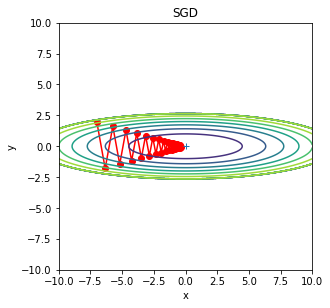

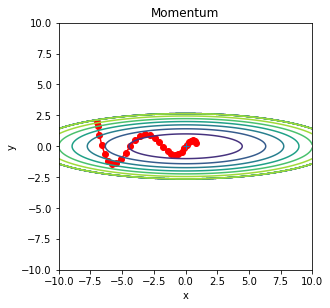

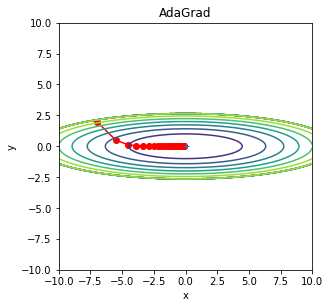

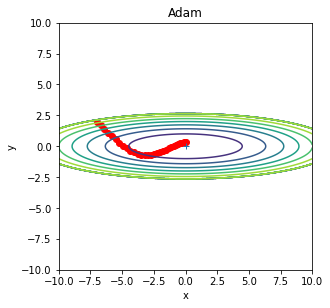

In [34]:
# 각 갱신방법을 비교
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.figure(figsize=(10,10))
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

===========iteration:0===========
SGD:2.52711652307294
Momentum:2.331192195911811
AdaGrad:2.2123096314984094
Adam:2.207800328987541
===========iteration:100===========
SGD:1.3001301968799361
Momentum:0.40022397584867175
AdaGrad:0.18478328153369272
Adam:0.30167529063150206
===========iteration:200===========
SGD:0.6276113972305148
Momentum:0.21078113772722426
AdaGrad:0.11671293740598912
Adam:0.20423229249081132
===========iteration:300===========
SGD:0.4932753721805966
Momentum:0.22173927060450976
AdaGrad:0.1158106589568649
Adam:0.19278441606853902
===========iteration:400===========
SGD:0.48766778489269214
Momentum:0.17558760072035742
AdaGrad:0.06024244287042578
Adam:0.10037012374434105
===========iteration:500===========
SGD:0.29689139826582833
Momentum:0.08676471615307792
AdaGrad:0.025802646998275724
Adam:0.041152054427714545
===========iteration:600===========
SGD:0.3080551552529067
Momentum:0.10041646999519648
AdaGrad:0.04105916015849975
Adam:0.07189477863272715
===========iteratio

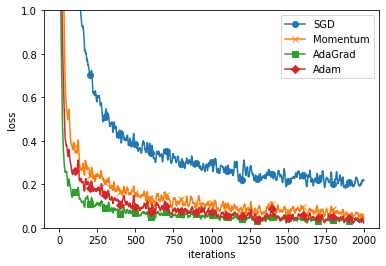

In [35]:
# MNIST 손글씨로 보는 갱신법 비교

import os
import sys
sys.path.append(os.pardir)
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet


# 0.MNIST 구성
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1.최적화 방법별 학습 생성
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2.학습
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.결과출력
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


In [36]:
# 가중치의 초깃값
# 초기 가중치를 모두 0으로 하면 학습이 제대로 이루어지지 않는다(정확히는 균일한 가중치값)
# 같은 초깃값에서 출발하면 갱신해도 값이 여전히 같다. 따라서 가중치가 대칭이 되지 않게 무작위로 설정해야한다.

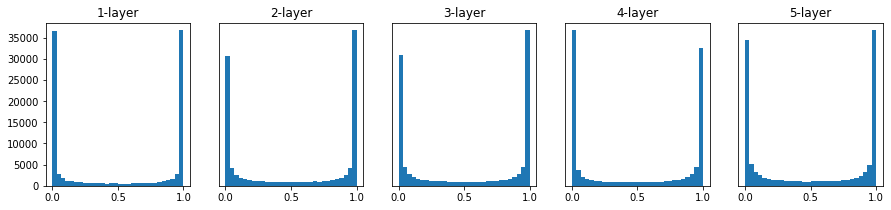

In [80]:
# 은닉층의 활성화값 분포
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 데이터 1000개
node_num = 100  # 각 은닉층의 node 수
hidden_layer_size = 5  # 은닉층 5개
activations = {}  # 이곳에 활성화된 결과(활성화값)을 

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# 각 층의 활성화값이 0과 1에 치우쳐져있다.
# 이렇게 데이터가 치우쳐지면 역전파의 기울기값이 점점 작아지다 사라지는 기울기 소실이 발생

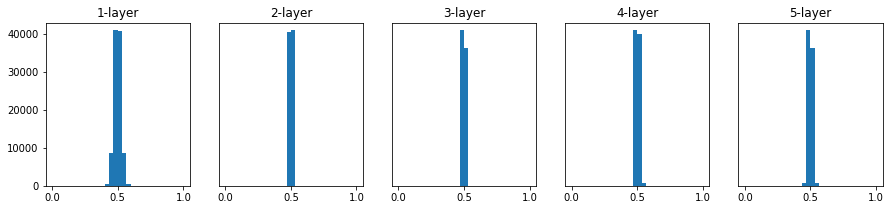

In [79]:
input_data = np.random.randn(1000, 100)  # 데이터 1000개
node_num = 100  # 각 은닉층의 node 수
hidden_layer_size = 5  # 은닉층 5개
activations = {}  # 이곳에 활성화된 결과(활성화값)을 

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# 초깃값 표준편차를 0.01로 한 경우. 0과 1로 치우치진 않았으나 표현력이 제한됨.

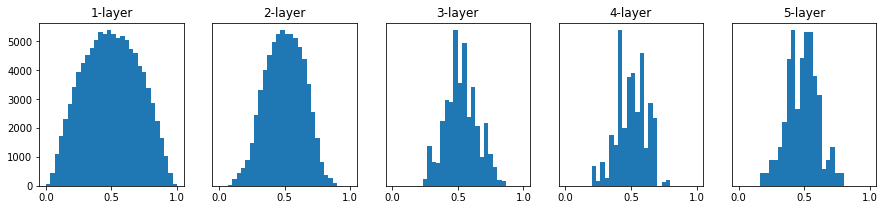

In [78]:
#Xavier 초깃값을 사용하면 확실히 넓게 분포된다
input_data = np.random.randn(1000, 100)  # 데이터 1000개
node_num = 100  # 각 은닉층의 node 수
hidden_layer_size = 5  # 은닉층 5개
activations = {}  # 이곳에 활성화된 결과(활성화값)을 

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) #책에 그냥 node_num으로 잘못적혀있는 듯 하다
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

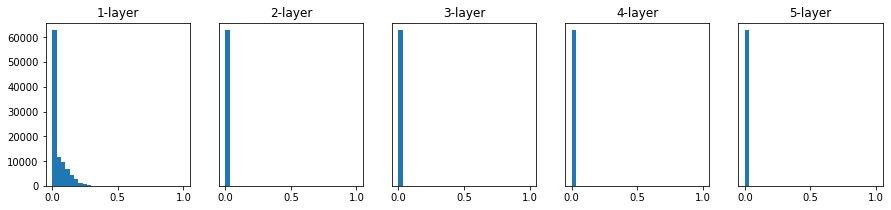

In [76]:
#Relu를 사용
input_data = np.random.randn(1000, 100)  # 데이터 1000개
node_num = 100  # 각 은닉층의 node 수
hidden_layer_size = 5  # 은닉층 5개
activations = {}  # 이곳에 활성화된 결과(활성화값)을 

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()
#Xavier 초깃값
input_data = np.random.randn(1000, 100)  # 데이터 1000개
node_num = 100  # 각 은닉층의 node 수
hidden_layer_size = 5  # 은닉층 5개
activations = {}  # 이곳에 활성화된 결과(활성화값)을 

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()
# 학습이 거의 이루어지지않음

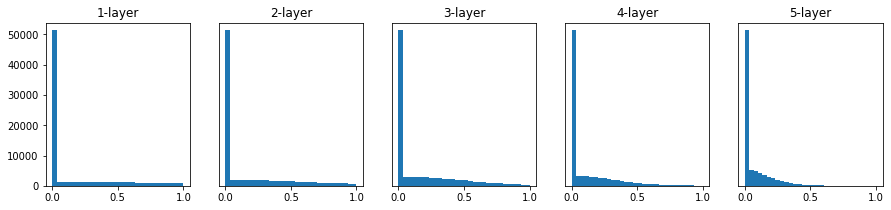

In [77]:
#Xavier 초깃값
input_data = np.random.randn(1000, 100)  # 데이터 1000개
node_num = 100  # 각 은닉층의 node 수
hidden_layer_size = 5  # 은닉층 5개
activations = {}  # 이곳에 활성화된 결과(활성화값)을 

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()
# 층이 깊어지면서 조금씩 치우침

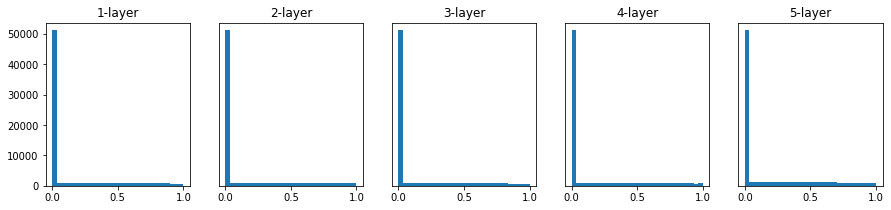

In [81]:
#He 초깃값
input_data = np.random.randn(1000, 100)  # 데이터 1000개
node_num = 100  # 각 은닉층의 node 수
hidden_layer_size = 5  # 은닉층 5개
activations = {}  # 이곳에 활성화된 결과(활성화값)을 

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()
# 층에 관계없이 균일한 분포

===========iteration:0===========
std=0.01:2.3025474157191397
Xavier:2.2946910683129853
He:2.4039004364544647
===========iteration:100===========
std=0.01:2.302549445044898
Xavier:2.2476757005122994
He:1.4581537156729563
===========iteration:200===========
std=0.01:2.302760911102447
Xavier:2.12880948351266
He:0.8100773073294926
===========iteration:300===========
std=0.01:2.3013945590828397
Xavier:1.900102044737587
He:0.5657412179212541
===========iteration:400===========
std=0.01:2.3039732032530713
Xavier:1.5141400285746678
He:0.47316746015860023
===========iteration:500===========
std=0.01:2.3018724440444402
Xavier:0.9493395562900622
He:0.3631174165969825
===========iteration:600===========
std=0.01:2.3000896392532226
Xavier:0.7748492625555662
He:0.5264521467570473
===========iteration:700===========
std=0.01:2.3021842784213895
Xavier:0.5930909770136346
He:0.3691065216127045
===========iteration:800===========
std=0.01:2.3060043422160668
Xavier:0.45018281115765024
He:0.25842286697398

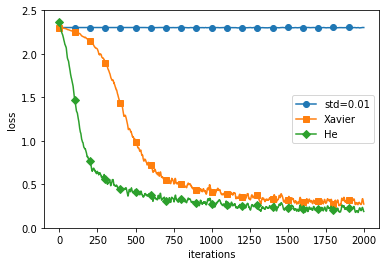

In [82]:
# MNIST로 비교
import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0.MNIST 구성
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1.최적화 방법별 학습 생성
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2.학습
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.결과
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

============== 1/16 ==============
epoch:0 | 0.1 - 0.08
epoch:1 | 0.097 - 0.094
epoch:2 | 0.097 - 0.122
epoch:3 | 0.097 - 0.132
epoch:4 | 0.097 - 0.15
epoch:5 | 0.097 - 0.167
epoch:6 | 0.097 - 0.187
epoch:7 | 0.097 - 0.2
epoch:8 | 0.097 - 0.221
epoch:9 | 0.097 - 0.241
epoch:10 | 0.097 - 0.256
epoch:11 | 0.097 - 0.278
epoch:12 | 0.097 - 0.293
epoch:13 | 0.097 - 0.304
epoch:14 | 0.097 - 0.325
epoch:15 | 0.097 - 0.342
epoch:16 | 0.097 - 0.355
epoch:17 | 0.097 - 0.376


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:18 | 0.097 - 0.375
epoch:19 | 0.097 - 0.389
============== 2/16 ==============
epoch:0 | 0.099 - 0.097
epoch:1 | 0.097 - 0.124
epoch:2 | 0.097 - 0.165
epoch:3 | 0.097 - 0.188
epoch:4 | 0.097 - 0.209
epoch:5 | 0.097 - 0.234
epoch:6 | 0.097 - 0.263
epoch:7 | 0.097 - 0.275
epoch:8 | 0.097 - 0.299
epoch:9 | 0.097 - 0.318
epoch:10 | 0.097 - 0.335
epoch:11 | 0.097 - 0.356
epoch:12 | 0.097 - 0.381
epoch:13 | 0.097 - 0.4
epoch:14 | 0.097 - 0.413
epoch:15 | 0.097 - 0.427
epoch:16 | 0.097 - 0.444
epoch:17 | 0.097 - 0.458
epoch:18 | 0.097 - 0.466


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.097 - 0.486
============== 3/16 ==============
epoch:0 | 0.094 - 0.132
epoch:1 | 0.316 - 0.17
epoch:2 | 0.422 - 0.242
epoch:3 | 0.504 - 0.274
epoch:4 | 0.595 - 0.296
epoch:5 | 0.658 - 0.322
epoch:6 | 0.708 - 0.349
epoch:7 | 0.758 - 0.384
epoch:8 | 0.78 - 0.411
epoch:9 | 0.817 - 0.44
epoch:10 | 0.841 - 0.475
epoch:11 | 0.885 - 0.508
epoch:12 | 0.899 - 0.525
epoch:13 | 0.913 - 0.545
epoch:14 | 0.921 - 0.562
epoch:15 | 0.944 - 0.585
epoch:16 | 0.943 - 0.598
epoch:17 | 0.952 - 0.615
epoch:18 | 0.955 - 0.626


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.968 - 0.651
============== 4/16 ==============
epoch:0 | 0.083 - 0.079
epoch:1 | 0.227 - 0.101
epoch:2 | 0.385 - 0.163
epoch:3 | 0.489 - 0.22
epoch:4 | 0.547 - 0.289
epoch:5 | 0.59 - 0.347
epoch:6 | 0.649 - 0.385
epoch:7 | 0.687 - 0.441
epoch:8 | 0.714 - 0.496
epoch:9 | 0.727 - 0.539
epoch:10 | 0.744 - 0.592
epoch:11 | 0.77 - 0.62
epoch:12 | 0.778 - 0.644
epoch:13 | 0.801 - 0.667
epoch:14 | 0.806 - 0.687
epoch:15 | 0.83 - 0.707
epoch:16 | 0.819 - 0.721
epoch:17 | 0.846 - 0.737
epoch:18 | 0.849 - 0.747


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.859 - 0.766
============== 5/16 ==============
epoch:0 | 0.084 - 0.112
epoch:1 | 0.083 - 0.13
epoch:2 | 0.081 - 0.276
epoch:3 | 0.086 - 0.406
epoch:4 | 0.092 - 0.514
epoch:5 | 0.104 - 0.598
epoch:6 | 0.108 - 0.652
epoch:7 | 0.116 - 0.69
epoch:8 | 0.131 - 0.716
epoch:9 | 0.148 - 0.748
epoch:10 | 0.161 - 0.769
epoch:11 | 0.18 - 0.792
epoch:12 | 0.212 - 0.796
epoch:13 | 0.209 - 0.814
epoch:14 | 0.221 - 0.822
epoch:15 | 0.234 - 0.828
epoch:16 | 0.263 - 0.839
epoch:17 | 0.272 - 0.849
epoch:18 | 0.287 - 0.858


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.323 - 0.868
============== 6/16 ==============
epoch:0 | 0.093 - 0.109
epoch:1 | 0.112 - 0.215
epoch:2 | 0.117 - 0.401
epoch:3 | 0.117 - 0.528
epoch:4 | 0.117 - 0.631
epoch:5 | 0.117 - 0.7
epoch:6 | 0.117 - 0.749
epoch:7 | 0.117 - 0.782
epoch:8 | 0.117 - 0.815
epoch:9 | 0.117 - 0.833
epoch:10 | 0.117 - 0.851
epoch:11 | 0.117 - 0.866
epoch:12 | 0.117 - 0.874
epoch:13 | 0.117 - 0.881
epoch:14 | 0.117 - 0.899
epoch:15 | 0.117 - 0.915
epoch:16 | 0.117 - 0.927
epoch:17 | 0.117 - 0.939
epoch:18 | 0.117 - 0.943


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.952
============== 7/16 ==============
epoch:0 | 0.105 - 0.092
epoch:1 | 0.116 - 0.272
epoch:2 | 0.117 - 0.598
epoch:3 | 0.117 - 0.691
epoch:4 | 0.116 - 0.736
epoch:5 | 0.116 - 0.786
epoch:6 | 0.116 - 0.807
epoch:7 | 0.116 - 0.828
epoch:8 | 0.116 - 0.859
epoch:9 | 0.116 - 0.883
epoch:10 | 0.116 - 0.894
epoch:11 | 0.116 - 0.909
epoch:12 | 0.116 - 0.924
epoch:13 | 0.116 - 0.935
epoch:14 | 0.116 - 0.954
epoch:15 | 0.116 - 0.968
epoch:16 | 0.116 - 0.97
epoch:17 | 0.116 - 0.973
epoch:18 | 0.116 - 0.978


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.984
============== 8/16 ==============
epoch:0 | 0.117 - 0.096
epoch:1 | 0.116 - 0.338
epoch:2 | 0.116 - 0.66
epoch:3 | 0.117 - 0.742
epoch:4 | 0.117 - 0.808
epoch:5 | 0.117 - 0.861
epoch:6 | 0.117 - 0.906
epoch:7 | 0.117 - 0.931
epoch:8 | 0.117 - 0.946
epoch:9 | 0.117 - 0.961
epoch:10 | 0.117 - 0.977
epoch:11 | 0.117 - 0.981
epoch:12 | 0.117 - 0.987
epoch:13 | 0.117 - 0.986
epoch:14 | 0.117 - 0.989
epoch:15 | 0.117 - 0.992
epoch:16 | 0.117 - 0.993
epoch:17 | 0.117 - 0.995
epoch:18 | 0.117 - 0.996
epoch:19 | 0.117 - 0.998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 9/16 ==============
epoch:0 | 0.117 - 0.1
epoch:1 | 0.116 - 0.452
epoch:2 | 0.116 - 0.677
epoch:3 | 0.116 - 0.75
epoch:4 | 0.116 - 0.824
epoch:5 | 0.116 - 0.86
epoch:6 | 0.116 - 0.913
epoch:7 | 0.116 - 0.95
epoch:8 | 0.116 - 0.97
epoch:9 | 0.117 - 0.983
epoch:10 | 0.116 - 0.988
epoch:11 | 0.116 - 0.995
epoch:12 | 0.116 - 0.997
epoch:13 | 0.116 - 0.996
epoch:14 | 0.116 - 0.998
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.117 - 0.097
epoch:1 | 0.116 - 0.621
epoch:2 | 0.117 - 0.731
epoch:3 | 0.117 - 0.683
epoch:4 | 0.116 - 0.802
epoch:5 | 0.117 - 0.865
epoch:6 | 0.117 - 0.88
epoch:7 | 0.117 - 0.947
epoch:8 | 0.117 - 0.987
epoch:9 | 0.117 - 0.987
epoch:10 | 0.117 - 0.992
epoch:11 | 0.116 - 0.992
epoch:12 | 0.116 - 0.982
epoch:13 | 0.117 - 0.995
epoch:14 | 0.117 - 0.995
epoch:15 | 0.116 - 0.997
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 1.0
============== 11/16 ==============
epoch:0 | 0.093 - 0.18
epoch:1 | 0.105 - 0.688
epoch:2 | 0.105 - 0.84
epoch:3 | 0.105 - 0.893
epoch:4 | 0.117 - 0.913
epoch:5 | 0.116 - 0.919
epoch:6 | 0.117 - 0.889
epoch:7 | 0.117 - 0.947
epoch:8 | 0.117 - 0.979
epoch:9 | 0.117 - 0.976
epoch:10 | 0.117 - 0.983
epoch:11 | 0.117 - 0.985
epoch:12 | 0.117 - 0.984
epoch:13 | 0.117 - 0.977
epoch:14 | 0.117 - 0.985
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.999
============== 12/16 ==============
epoch:0 | 0.116 - 0.192
epoch:1 | 0.116 - 0.617
epoch:2 | 0.116 - 0.716
epoch:3 | 0.116 - 0.609
epoch:4 | 0.116 - 0.759
epoch:5 | 0.116 - 0.783
epoch:6 | 0.117 - 0.857
epoch:7 | 0.117 - 0.831
epoch:8 | 0.117 - 0.815
epoch:9 | 0.116 - 0.871
epoch:10 | 0.117 - 0.887
epoch:11 | 0.116 - 0.864
epoch:12 | 0.117 - 0.855
epoch:13 | 0.117 - 0.888
epoch:14 | 0.117 - 0.894
epoch:15 | 0.116 - 0.897
epoch:16 | 0.116 - 0.898
epoch:17 | 0.116 - 0.893
epoch:18 | 0.116 - 0.895


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.116 - 0.897
============== 13/16 ==============
epoch:0 | 0.099 - 0.145
epoch:1 | 0.116 - 0.411
epoch:2 | 0.117 - 0.635
epoch:3 | 0.116 - 0.681
epoch:4 | 0.117 - 0.644
epoch:5 | 0.116 - 0.615
epoch:6 | 0.116 - 0.69
epoch:7 | 0.116 - 0.674
epoch:8 | 0.116 - 0.703
epoch:9 | 0.116 - 0.728
epoch:10 | 0.116 - 0.719
epoch:11 | 0.116 - 0.724
epoch:12 | 0.116 - 0.725
epoch:13 | 0.116 - 0.731
epoch:14 | 0.116 - 0.722
epoch:15 | 0.116 - 0.714
epoch:16 | 0.116 - 0.715
epoch:17 | 0.116 - 0.598
epoch:18 | 0.116 - 0.712


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch:19 | 0.117 - 0.716
============== 14/16 ==============
epoch:0 | 0.116 - 0.29
epoch:1 | 0.117 - 0.374
epoch:2 | 0.117 - 0.389
epoch:3 | 0.117 - 0.381
epoch:4 | 0.117 - 0.483
epoch:5 | 0.117 - 0.412
epoch:6 | 0.116 - 0.485
epoch:7 | 0.117 - 0.498
epoch:8 | 0.117 - 0.498
epoch:9 | 0.117 - 0.503
epoch:10 | 0.116 - 0.508
epoch:11 | 0.116 - 0.505
epoch:12 | 0.116 - 0.483
epoch:13 | 0.116 - 0.485
epoch:14 | 0.117 - 0.503
epoch:15 | 0.117 - 0.49
epoch:16 | 0.117 - 0.579
epoch:17 | 0.117 - 0.582
epoch:18 | 0.117 - 0.437
epoch:19 | 0.117 - 0.588


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 15/16 ==============
epoch:0 | 0.099 - 0.147
epoch:1 | 0.117 - 0.399
epoch:2 | 0.117 - 0.412
epoch:3 | 0.117 - 0.415
epoch:4 | 0.117 - 0.421
epoch:5 | 0.117 - 0.494
epoch:6 | 0.117 - 0.492
epoch:7 | 0.117 - 0.511
epoch:8 | 0.117 - 0.484
epoch:9 | 0.117 - 0.507
epoch:10 | 0.117 - 0.519
epoch:11 | 0.117 - 0.516
epoch:12 | 0.117 - 0.497
epoch:13 | 0.117 - 0.523
epoch:14 | 0.117 - 0.523
epoch:15 | 0.117 - 0.53
epoch:16 | 0.117 - 0.53
epoch:17 | 0.117 - 0.529
epoch:18 | 0.117 - 0.53
epoch:19 | 0.117 - 0.525


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 16/16 ==============
epoch:0 | 0.116 - 0.197
epoch:1 | 0.117 - 0.289
epoch:2 | 0.117 - 0.313
epoch:3 | 0.117 - 0.324
epoch:4 | 0.117 - 0.386
epoch:5 | 0.117 - 0.425
epoch:6 | 0.117 - 0.417
epoch:7 | 0.117 - 0.423
epoch:8 | 0.117 - 0.382
epoch:9 | 0.117 - 0.399
epoch:10 | 0.117 - 0.439
epoch:11 | 0.117 - 0.434
epoch:12 | 0.117 - 0.423
epoch:13 | 0.117 - 0.327
epoch:14 | 0.117 - 0.413
epoch:15 | 0.117 - 0.421
epoch:16 | 0.117 - 0.428
epoch:17 | 0.117 - 0.432
epoch:18 | 0.117 - 0.426
epoch:19 | 0.116 - 0.43


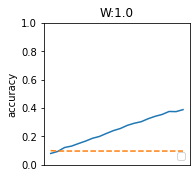

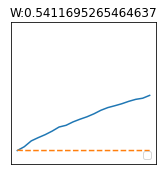

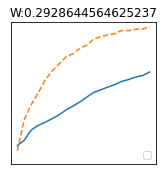

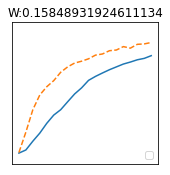

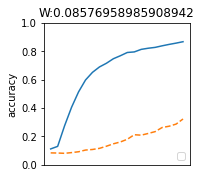

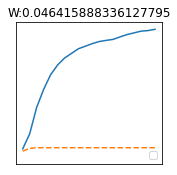

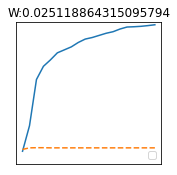

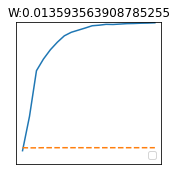

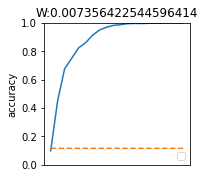

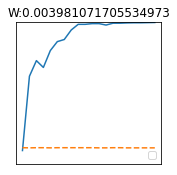

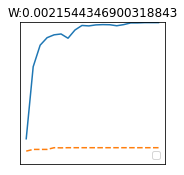

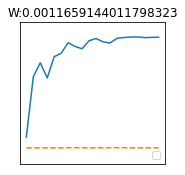

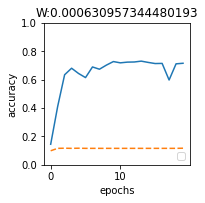

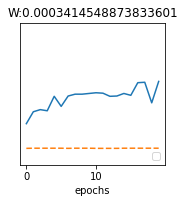

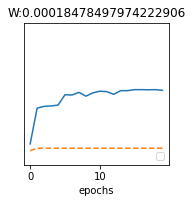

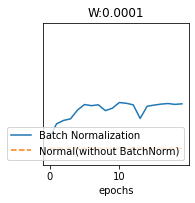

In [89]:
# 배치 정규화 : 각 층의 활성화값이 적당히 분포되도록 조정하는 것
# 학습이 빠르고 초깃값에 의존하지 않으며 오버피팅 억제

import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    plt.figure(figsize=(12, 12))
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

epoch:0, train acc:0.11666666666666667, test acc:0.106
epoch:1, train acc:0.11333333333333333, test acc:0.1228
epoch:2, train acc:0.12, test acc:0.1276
epoch:3, train acc:0.14666666666666667, test acc:0.1425
epoch:4, train acc:0.17333333333333334, test acc:0.1576
epoch:5, train acc:0.21, test acc:0.1856
epoch:6, train acc:0.24, test acc:0.2022
epoch:7, train acc:0.27, test acc:0.2233
epoch:8, train acc:0.30666666666666664, test acc:0.2479
epoch:9, train acc:0.34, test acc:0.2663
epoch:10, train acc:0.35333333333333333, test acc:0.2705
epoch:11, train acc:0.36333333333333334, test acc:0.2862
epoch:12, train acc:0.37, test acc:0.2933
epoch:13, train acc:0.4066666666666667, test acc:0.3062
epoch:14, train acc:0.42333333333333334, test acc:0.3171
epoch:15, train acc:0.43333333333333335, test acc:0.3287
epoch:16, train acc:0.46, test acc:0.3486
epoch:17, train acc:0.4666666666666667, test acc:0.3582
epoch:18, train acc:0.49333333333333335, test acc:0.3707
epoch:19, train acc:0.5033333333333

epoch:160, train acc:0.8833333333333333, test acc:0.7344
epoch:161, train acc:0.86, test acc:0.728
epoch:162, train acc:0.8833333333333333, test acc:0.7333
epoch:163, train acc:0.87, test acc:0.7239
epoch:164, train acc:0.8666666666666667, test acc:0.7192
epoch:165, train acc:0.8866666666666667, test acc:0.7269
epoch:166, train acc:0.88, test acc:0.7252
epoch:167, train acc:0.88, test acc:0.73
epoch:168, train acc:0.8833333333333333, test acc:0.722
epoch:169, train acc:0.8833333333333333, test acc:0.7257
epoch:170, train acc:0.89, test acc:0.7303
epoch:171, train acc:0.88, test acc:0.7285
epoch:172, train acc:0.8733333333333333, test acc:0.7284
epoch:173, train acc:0.8866666666666667, test acc:0.7341
epoch:174, train acc:0.88, test acc:0.7324
epoch:175, train acc:0.8666666666666667, test acc:0.7254
epoch:176, train acc:0.8766666666666667, test acc:0.7231
epoch:177, train acc:0.89, test acc:0.7276
epoch:178, train acc:0.8866666666666667, test acc:0.7294
epoch:179, train acc:0.8866666666

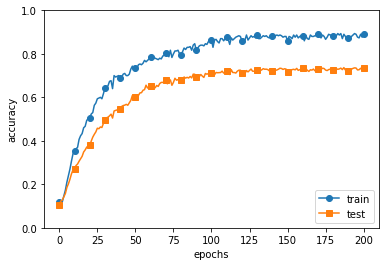

In [87]:
# 오버피팅 : 훈련 데이터에만 지나치게 적응되어 실전에 대응하지 못하는 것 
# 오버피팅은 매개변수가 많고 표현력이 높으며 데이터가 적을때 많이 발생
# 오버피팅 억제 : 가중치 감소

import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

#오버피팅을 재현하고자 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

weight_decay_lambda = 0.1

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
#오버피팅이 억제되었으며 훈련 데이터에 대한 정확도 역시 감소

In [92]:
# dropout
# 은닉층 뉴런을 임의로 삭제하는 것

class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio 
            # x와 형상 같은 배열 무작위 생성, dropout_ratio보다 큰 원소만 True로 설정
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

train loss:2.2927679195938695
=== epoch:1, train acc:0.11666666666666667, test acc:0.0986 ===
train loss:2.3008186944879245
train loss:2.296897521229248
train loss:2.286427592206008
=== epoch:2, train acc:0.12, test acc:0.0992 ===
train loss:2.298842764325982
train loss:2.2937098265419364
train loss:2.278628516982806
=== epoch:3, train acc:0.12, test acc:0.1003 ===
train loss:2.2940599833145874
train loss:2.2881755137941964
train loss:2.287222145992961
=== epoch:4, train acc:0.12333333333333334, test acc:0.1012 ===
train loss:2.2795322032606045
train loss:2.2856072640565244
train loss:2.2888033355198623
=== epoch:5, train acc:0.12666666666666668, test acc:0.1027 ===
train loss:2.2838873501360237
train loss:2.290186987109936
train loss:2.296747361088574
=== epoch:6, train acc:0.12666666666666668, test acc:0.1033 ===
train loss:2.2851384222258115
train loss:2.28653095777316
train loss:2.2896658424172385
=== epoch:7, train acc:0.12333333333333334, test acc:0.104 ===
train loss:2.290049404

=== epoch:56, train acc:0.3, test acc:0.2511 ===
train loss:2.2488877410619903
train loss:2.2356162896772087
train loss:2.247877273603432
=== epoch:57, train acc:0.31333333333333335, test acc:0.2561 ===
train loss:2.238112247683998
train loss:2.2193890638399374
train loss:2.2219737250771017
=== epoch:58, train acc:0.30666666666666664, test acc:0.2556 ===
train loss:2.225641069656387
train loss:2.2568856454233277
train loss:2.2589845776934454
=== epoch:59, train acc:0.31333333333333335, test acc:0.2572 ===
train loss:2.2254228654464008
train loss:2.229124927646848
train loss:2.260639128301735
=== epoch:60, train acc:0.31, test acc:0.2531 ===
train loss:2.222751778531491
train loss:2.242930133462417
train loss:2.214255548155401
=== epoch:61, train acc:0.31333333333333335, test acc:0.2534 ===
train loss:2.2377674888962975
train loss:2.2240118612051507
train loss:2.227951822936029
=== epoch:62, train acc:0.31333333333333335, test acc:0.2531 ===
train loss:2.2392439370174264
train loss:2.20

=== epoch:111, train acc:0.3466666666666667, test acc:0.2934 ===
train loss:2.138987703985529
train loss:2.1292838362338076
train loss:2.1446035525804534
=== epoch:112, train acc:0.3433333333333333, test acc:0.2933 ===
train loss:2.1569871951099118
train loss:2.1321923204683095
train loss:2.1170205459380766
=== epoch:113, train acc:0.33666666666666667, test acc:0.2925 ===
train loss:2.169319282006813
train loss:2.1106920060526373
train loss:2.1113508591025676
=== epoch:114, train acc:0.35, test acc:0.2943 ===
train loss:2.1522435066740657
train loss:2.1354345647647035
train loss:2.1627124118027314
=== epoch:115, train acc:0.35, test acc:0.2941 ===
train loss:2.1263493052849567
train loss:2.1481259829750665
train loss:2.073861754779652
=== epoch:116, train acc:0.35, test acc:0.2951 ===
train loss:2.162759998808412
train loss:2.0485975018311824
train loss:2.142218479000715
=== epoch:117, train acc:0.35, test acc:0.2958 ===
train loss:2.1032615187724932
train loss:2.084167849951544
train 

=== epoch:167, train acc:0.36333333333333334, test acc:0.3053 ===
train loss:1.979333926756161
train loss:1.8894648646325358
train loss:1.93958665833617
=== epoch:168, train acc:0.36333333333333334, test acc:0.3062 ===
train loss:1.8281501744225486
train loss:1.9449597853233527
train loss:1.8578914522307004
=== epoch:169, train acc:0.36666666666666664, test acc:0.3054 ===
train loss:1.8818024952821253
train loss:1.9068069169741646
train loss:1.8866574641304128
=== epoch:170, train acc:0.36333333333333334, test acc:0.3066 ===
train loss:1.9872762456924635
train loss:1.9036248576436483
train loss:2.0043937817646515
=== epoch:171, train acc:0.36666666666666664, test acc:0.3087 ===
train loss:1.9437401916464583
train loss:1.9380182762906544
train loss:1.859557895745623
=== epoch:172, train acc:0.37333333333333335, test acc:0.3098 ===
train loss:1.933869759630523
train loss:1.9656865731501194
train loss:1.8236149313119916
=== epoch:173, train acc:0.37333333333333335, test acc:0.3097 ===
tra

=== epoch:222, train acc:0.45666666666666667, test acc:0.3662 ===
train loss:1.6511858969011808
train loss:1.7488551912796622
train loss:1.733296908477571
=== epoch:223, train acc:0.47, test acc:0.3697 ===
train loss:1.594361749419166
train loss:1.67566764498799
train loss:1.7258580860006003
=== epoch:224, train acc:0.47, test acc:0.3694 ===
train loss:1.759576648424376
train loss:1.7771016944130429
train loss:1.5724805125293129
=== epoch:225, train acc:0.4666666666666667, test acc:0.373 ===
train loss:1.684399769865167
train loss:1.744663014681917
train loss:1.623983482104312
=== epoch:226, train acc:0.47333333333333333, test acc:0.373 ===
train loss:1.6934063799200572
train loss:1.626995309869164
train loss:1.7424962657468877
=== epoch:227, train acc:0.48, test acc:0.3792 ===
train loss:1.6547055156097605
train loss:1.5659067233405417
train loss:1.6568807847896714
=== epoch:228, train acc:0.4766666666666667, test acc:0.384 ===
train loss:1.697745749028905
train loss:1.767180357957710

=== epoch:277, train acc:0.5633333333333334, test acc:0.4738 ===
train loss:1.3202008009577588
train loss:1.3216901311463263
train loss:1.4514603296853354
=== epoch:278, train acc:0.56, test acc:0.4721 ===
train loss:1.3088440938803734
train loss:1.3675621169664196
train loss:1.3753790288297518
=== epoch:279, train acc:0.5666666666666667, test acc:0.4733 ===
train loss:1.410281713819384
train loss:1.445710218623939
train loss:1.2821173954566345
=== epoch:280, train acc:0.5733333333333334, test acc:0.4746 ===
train loss:1.315504653719465
train loss:1.2785877176954044
train loss:1.400303166424233
=== epoch:281, train acc:0.5633333333333334, test acc:0.4732 ===
train loss:1.3970217497623736
train loss:1.403853736339356
train loss:1.3086119256306568
=== epoch:282, train acc:0.5733333333333334, test acc:0.4742 ===
train loss:1.4400981667300874
train loss:1.295968857014125
train loss:1.2152714918194494
=== epoch:283, train acc:0.57, test acc:0.4725 ===
train loss:1.4632138275434565
train los

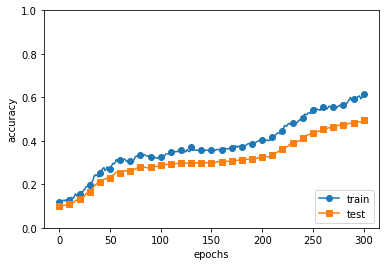

In [91]:
# 드롭아웃 적용결과 확인
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300]
t_train = t_train[:300]

use_dropout = True
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# ==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

val acc:0.11 | lr:1.3108343941780878e-05, weight decay:1.4781250387052652e-07
val acc:0.44 | lr:0.0036422304663211386, weight decay:3.195651305447032e-08
val acc:0.12 | lr:9.630955249421892e-06, weight decay:1.0681397555697066e-06
val acc:0.15 | lr:0.0011528328760803494, weight decay:7.10456267786341e-07
val acc:0.08 | lr:6.95220539109209e-05, weight decay:1.2527695648896828e-06
val acc:0.18 | lr:0.0009539217160317863, weight decay:5.420291700385541e-06
val acc:0.13 | lr:6.296997958214388e-05, weight decay:7.335029254607478e-07
val acc:0.06 | lr:2.0426068792410628e-05, weight decay:5.663142588353115e-05
val acc:0.16 | lr:0.0001718594799920119, weight decay:6.437994254729635e-06
val acc:0.04 | lr:5.33875388107111e-06, weight decay:4.2876602780090415e-07
val acc:0.15 | lr:0.00031259281275625525, weight decay:1.1813197867306652e-07
val acc:0.75 | lr:0.00919350057124095, weight decay:3.1623215534041704e-07
val acc:0.17 | lr:0.00019047699629822773, weight decay:4.074691252432573e-06
val acc

Best-8(val acc:0.69) | lr:0.006956264282153468, weight decay:5.540500561355809e-05
Best-9(val acc:0.67) | lr:0.005539176791947836, weight decay:1.5374455369949027e-08
Best-10(val acc:0.62) | lr:0.005590624093506219, weight decay:4.149096336748332e-08
Best-11(val acc:0.62) | lr:0.0033310649824389435, weight decay:3.4501404137418525e-05
Best-12(val acc:0.59) | lr:0.0038355978078841576, weight decay:1.7314485567525068e-06
Best-13(val acc:0.48) | lr:0.003272869059385394, weight decay:6.992987678743326e-06
Best-14(val acc:0.44) | lr:0.0036422304663211386, weight decay:3.195651305447032e-08
Best-15(val acc:0.43) | lr:0.002974359715563941, weight decay:1.2473526750160497e-07
Best-16(val acc:0.43) | lr:0.0019504581501326144, weight decay:9.518589264159219e-07
Best-17(val acc:0.4) | lr:0.001988385072224376, weight decay:7.214963575712896e-08
Best-18(val acc:0.34) | lr:0.001598233096473471, weight decay:3.541521042534236e-05
Best-19(val acc:0.34) | lr:0.0025130498868424253, weight decay:7.578804

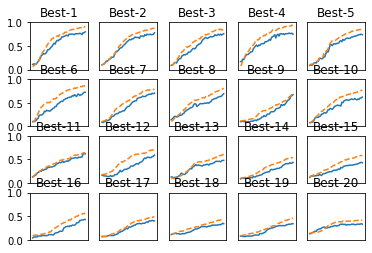

In [93]:
# 적절한 하이퍼파라미터 값 찾기
# 하이퍼파라미터 전용 데이터인 검증 데이터를 사용
# 최적값이 존재하는 범위를 점점 줄여나가는 방법

import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:500]
t_train = t_train[:500]

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()